# Dataset

In [2]:
import numpy as np
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import v2


import sys
sys.path.append("..")  # Adjust path to import from src

from src.dataset.dataset import HSIDataset
from src.util.constants import HELICOID_DIR, RING_LABELS_DIR


dataset = HSIDataset(HELICOID_DIR, ring_label_dir=RING_LABELS_DIR)
dataset.crop_dataset()

# Segmentation Model Split
# train_indices = list(range(0, 19))
# val_indices = list(range(19, 24))
# test_indices = list(range(24, 36))

# Autoencoder Split
train_indices = list(range(0, 33))
val_indices = list(range(33, 35))
test_indices = list(range(35, 36))

trainset = Subset(dataset, train_indices)
valset = Subset(dataset, val_indices)
testset = Subset(dataset, test_indices)

trainloader = DataLoader(trainset, batch_size=2, shuffle=True)
validationloader = DataLoader(valset, batch_size=2, shuffle=False)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

# Windowing

778.821
887.957


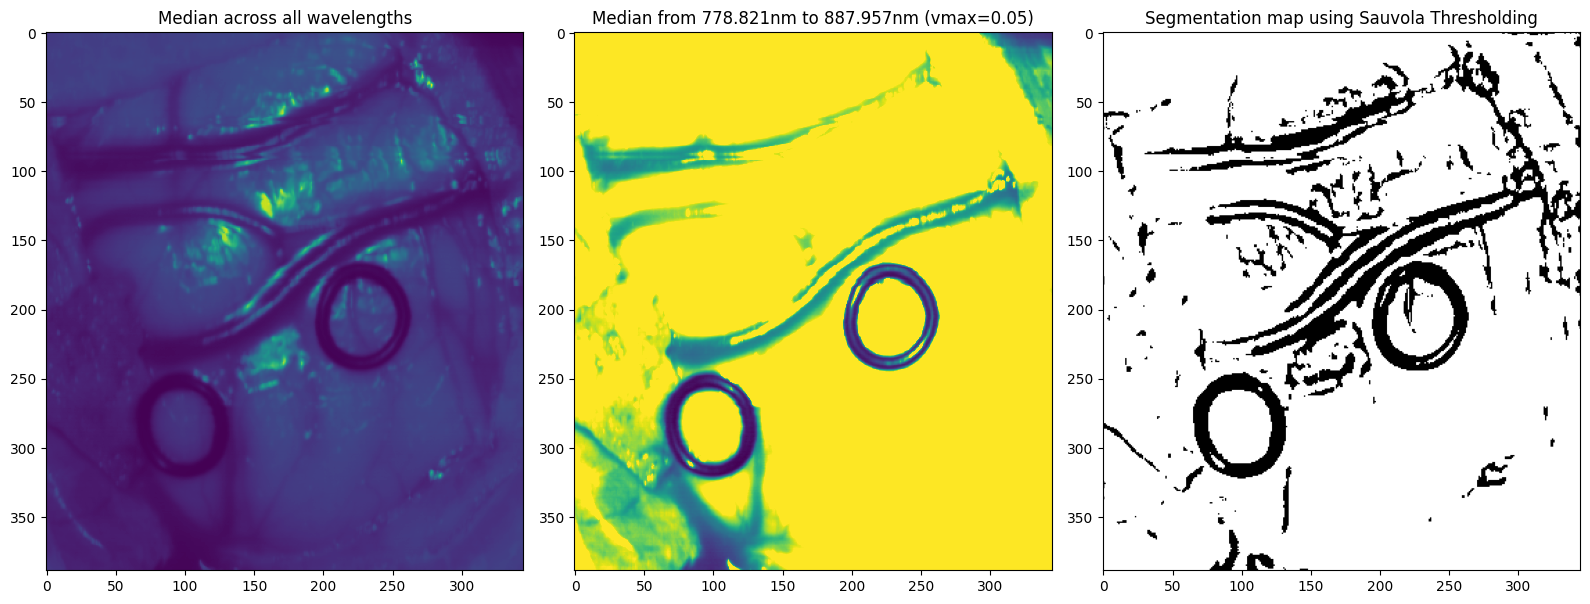

In [6]:
# patient = "012-02"
# patient = "025-02"
# patient = "015-01"
# patient = "012-01"
# patient = "016-04"
# patient = "008-01"
# patient = "020-01"
patient = "004-02"
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
import glob
import pickle
from scipy.linalg import pinv
import time
from tqdm import tqdm
from skimage import filters, color, io
from matplotlib.ticker import LinearLocator
import skimage

import pickle
import matplotlib.pyplot as plt
import random
from matplotlib.colors import Normalize
from PIL import Image
from spectral import open_image
import matplotlib.cm as cm


# left=140
# right=280
# left=200
# right=201
left = 520
right = 670


hdr_path = HELICOID_DIR / f"{patient}/raw.hdr"
img = open_image(hdr_path)
wavelength = np.array(img.metadata["wavelength"]).astype(float)
print(wavelength[left])
print(wavelength[right])
# print(np.where((wavelength >= 700) & (wavelength <= 900))[0])

white_path = HELICOID_DIR / f"{patient}/whiteReference.hdr"
white = open_image(white_path)
white = white.load()

dark_path = HELICOID_DIR / f"{patient}/darkReference.hdr"

dark = open_image(dark_path)
dark = dark.load()

white_full = np.tile(white, (img.shape[0], 1, 1))
dark_full = np.tile(dark, (img.shape[0], 1, 1))

img_normalized = (img.load() - dark_full) / (white_full - dark_full)
# img_normalized = ((img.load() - dark_full) / (white_full - dark_full))+0.1
img_normalized[img_normalized <= 0] = 10**-2

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
axs[0].imshow(np.median(img_normalized, axis=2))
axs[0].set_title("Median across all wavelengths")
median_hb = np.median(img_normalized[:, :, left:right], axis=2)
median_hb_normalized = (median_hb - np.min(median_hb)) / (
    np.max(median_hb) - np.min(median_hb)
)
plt2 = axs[1].imshow(median_hb_normalized, vmax=0.05)
axs[1].set_title(
    "Median from "
    + str(wavelength[left])
    + "nm to "
    + str(wavelength[right])
    + "nm (vmax=0.05)"
)
axs[2].imshow(
    (median_hb_normalized > filters.threshold_sauvola(median_hb_normalized)),
    cmap="gray",
)
axs[2].set_title("Segmentation map using Sauvola Thresholding")
plt.tight_layout()
# plt.savefig(plot_dir + "segm")
# plt3 = axs[2].imshow((median_hb < 0.3)*median_hb)

# Visualize Data

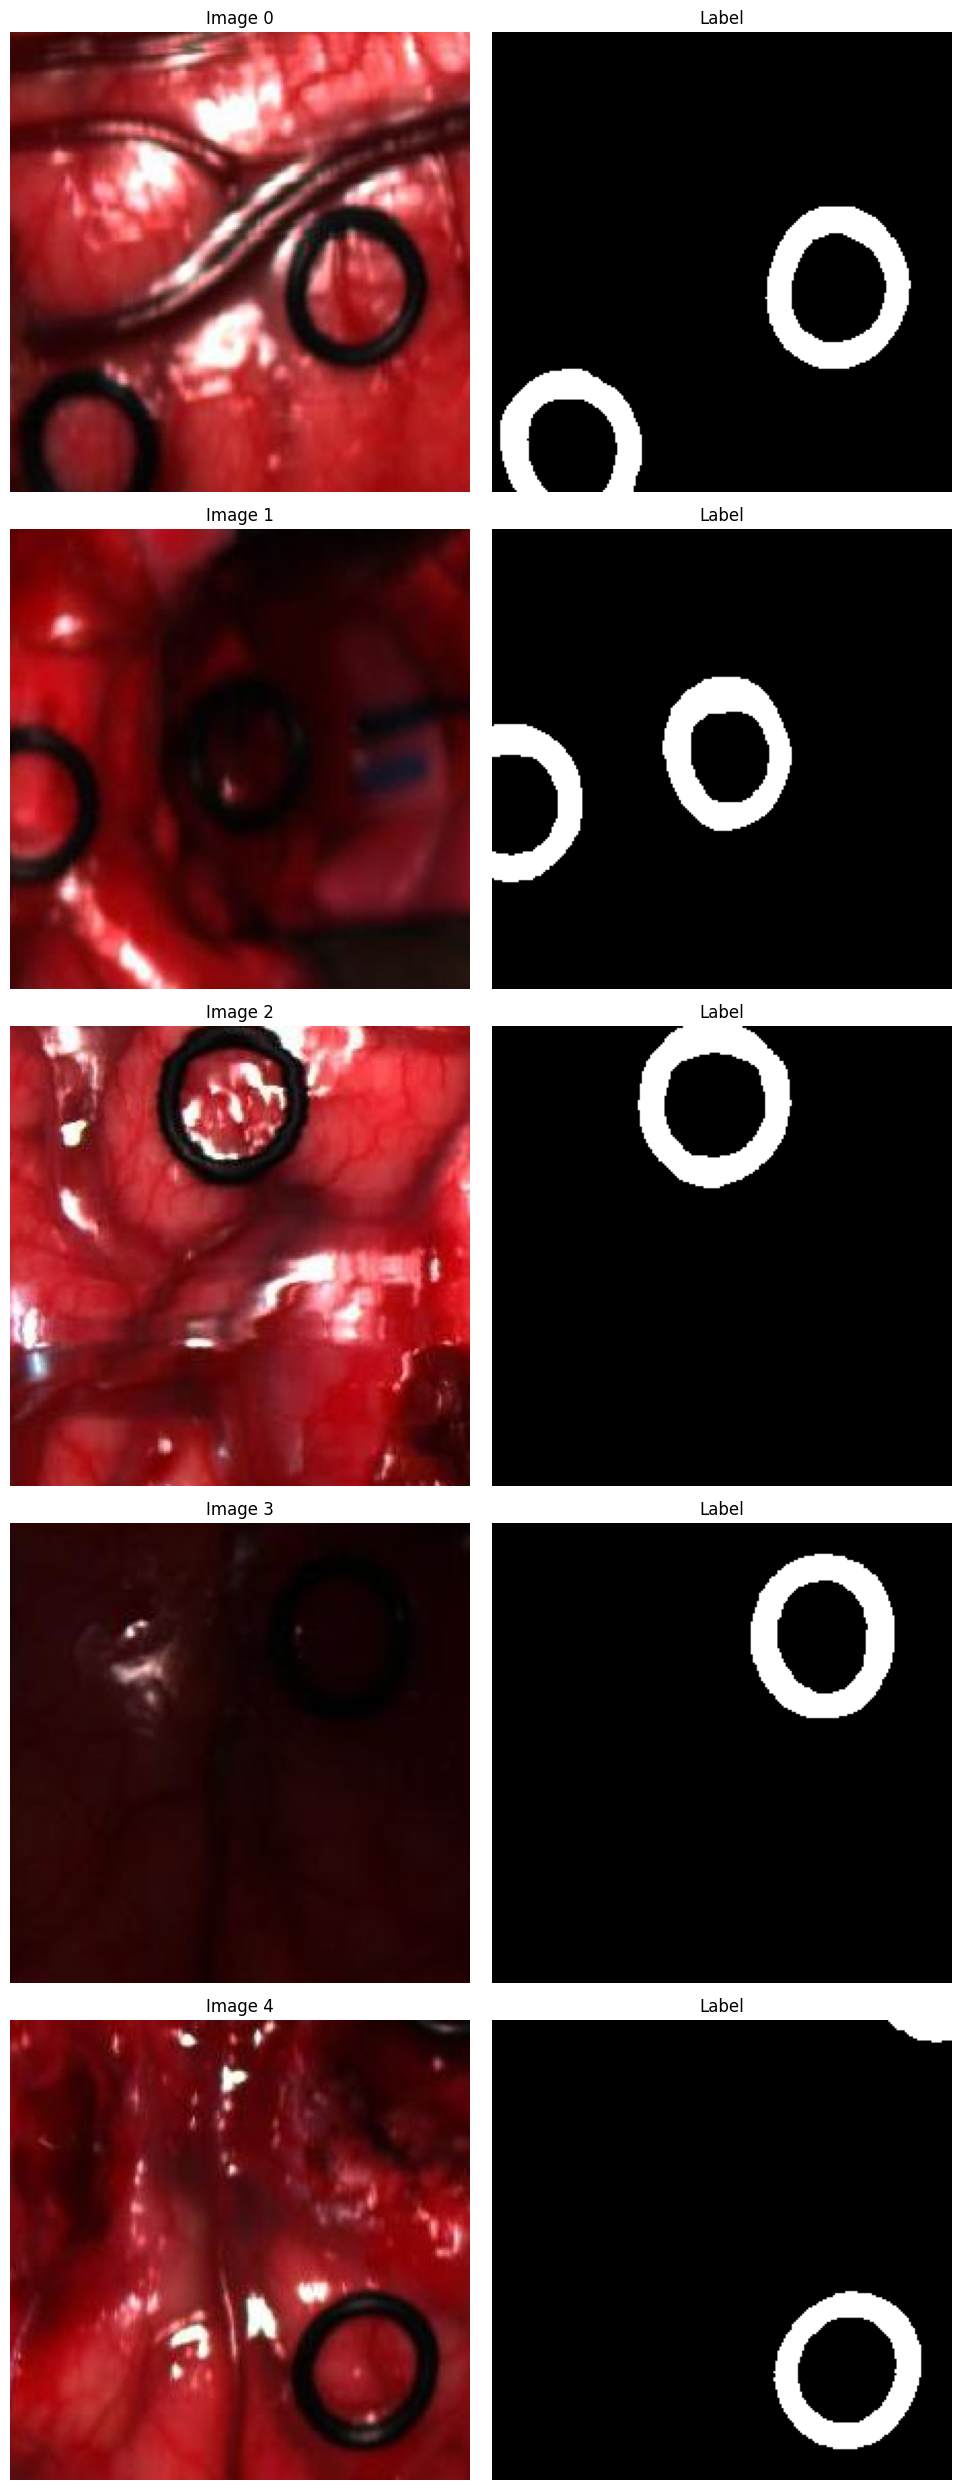

In [7]:
from src.dataset.dataset import create_montage
import numpy as np

create_montage(dataset, num_images=5)

# Model Initialization

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from src.util.segmentation_util import model_pipeline, load_model
from src.util.constants import MODELS_DIR
import torch.nn.functional as F
from src.model.HSI_models.HSI_Net import HyperspectralToGrayscale, CombinedModel, ConvolutionalReducer, Unet

config = {
    'model': 'Test-model',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': 1,
    'optimizer': 'Adam',
    'criterion': 'BCELoss',
}

segmenter = smp.Linknet('timm-regnetx_320', in_channels=1, classes=1)
model_path = MODELS_DIR / "Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth"

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

segmenter = load_model(segmenter, model_path, device=device)
encoder = HyperspectralToGrayscale()
model = CombinedModel(encoder, segmenter)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

# Training

In [ ]:
import matplotlib.pyplot as plt
from src.util.segmentation_util import model_pipeline


model, train_losses, val_losses = model_pipeline(model, trainloader=trainloader, 
                                                 validationloader=validationloader, 
                                                 testloader=testloader, criterion=criterion, 
                                                 optimizer=optimizer,project='hsi-segmentation',
                                                 model_name=config['model'],
                                                 device=device, config=config, 
                                                 batch_print=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
from src.util.segmentation_util import show_overlay

show_overlay(model, testset[0], device)

# Autoencoder Approach:
## Standard Autoencoder

In [ ]:
from src.training.train_autoencoder import model_pipeline_autoencoder
from src.model.dimensionality_reduction.autoencoder import Autoencoder
import torch.nn as nn
from torchsummary import summary

config = {
    'model': 'autoencoder-single-channel-with-normalized-cropped-data-deeper',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'MSELoss',
}

autoencoder = Autoencoder(output_channels=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

autoencoder, train_losses, val_losses = model_pipeline_autoencoder(autoencoder,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                criterion=criterion, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)

## Variational Autoencoder

In [ ]:
from src.training.train_autoencoder import model_pipeline_variational_autoencoder
from src.model.dimensionality_reduction.autoencoder import VariationalAutoencoder

from torchsummary import summary

config = {
    'model': 'variational-autoencoder',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'vae_loss',
}

vae = VariationalAutoencoder()
optimizer = torch.optim.Adam(vae.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

vae, train_losses, val_losses = model_pipeline_variational_autoencoder(vae,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)

# Ensemble Model Approach:

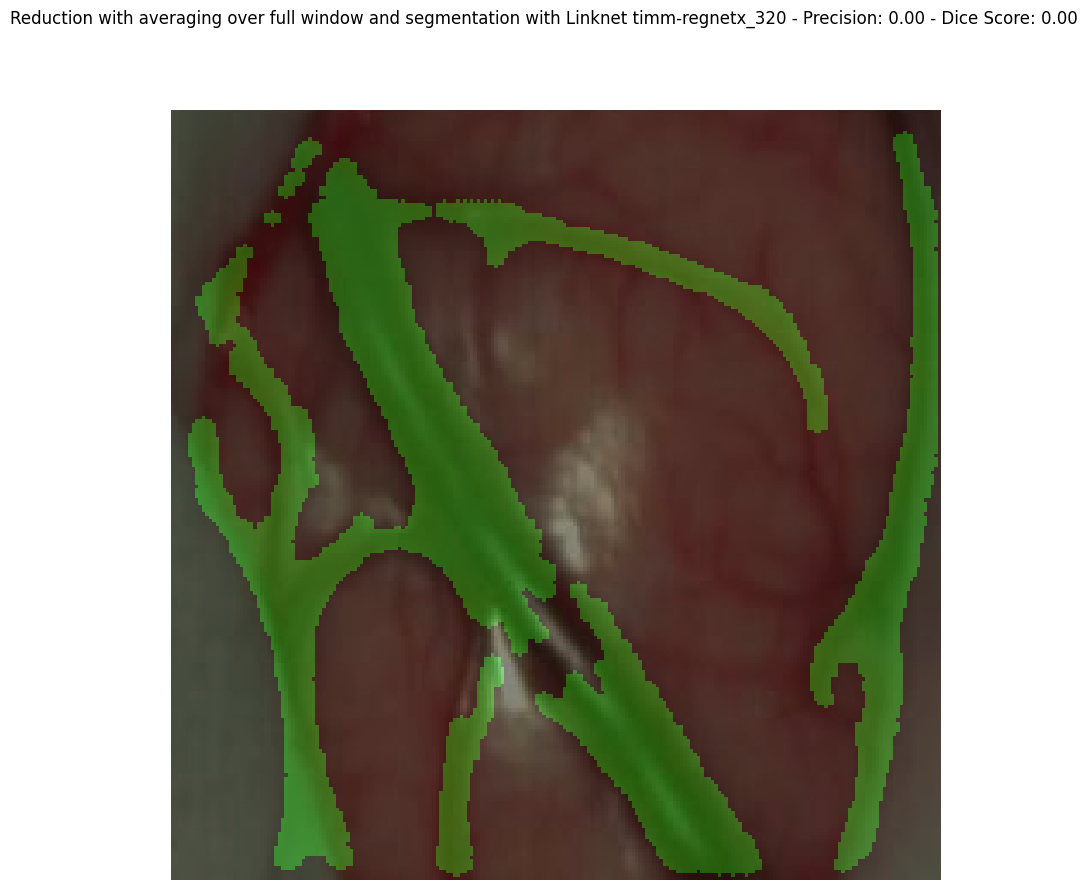

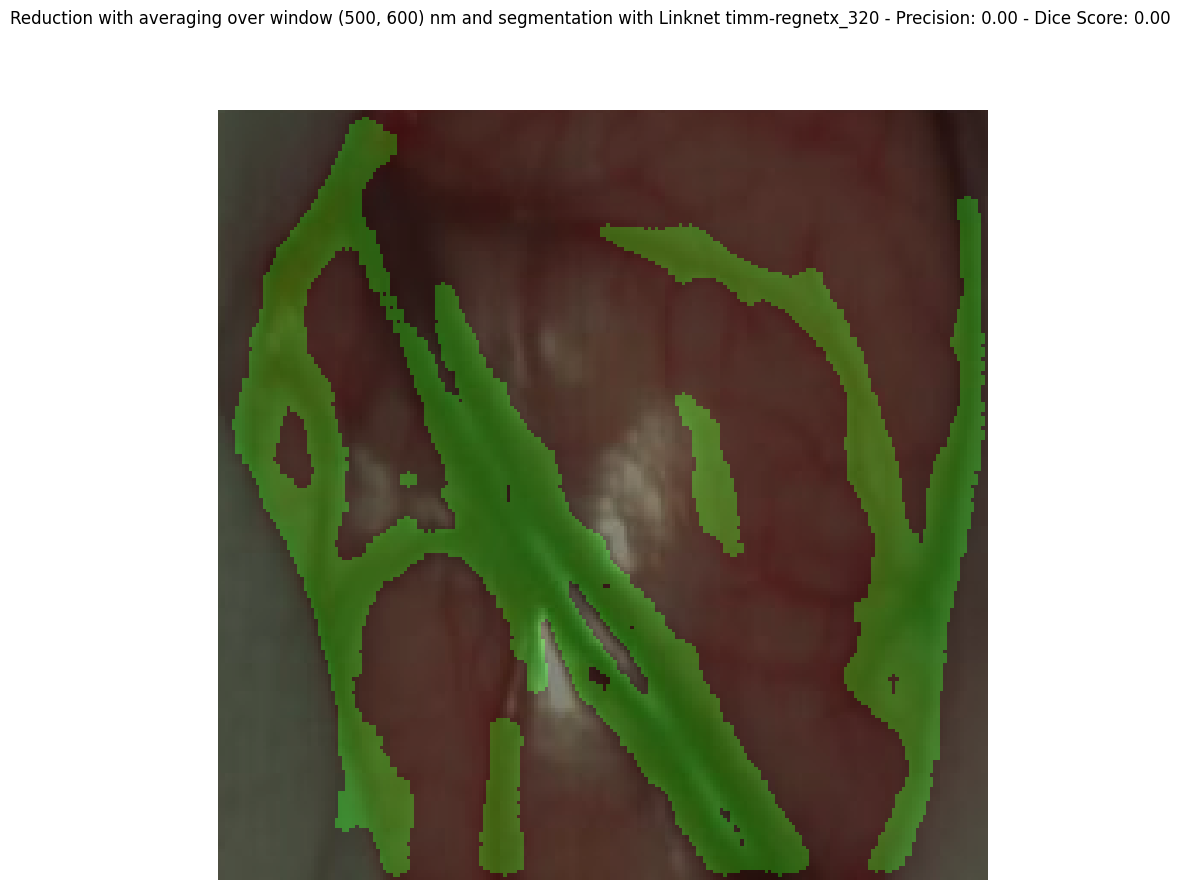

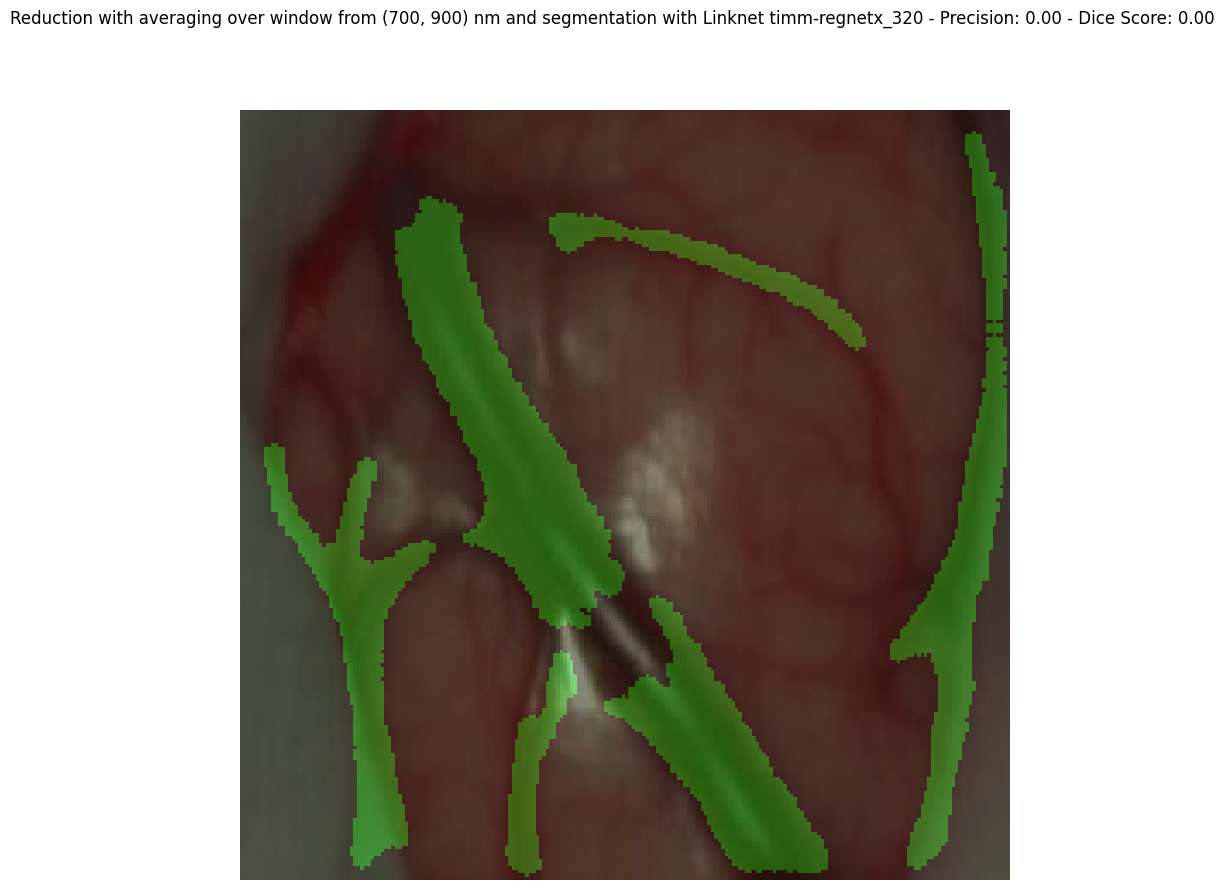

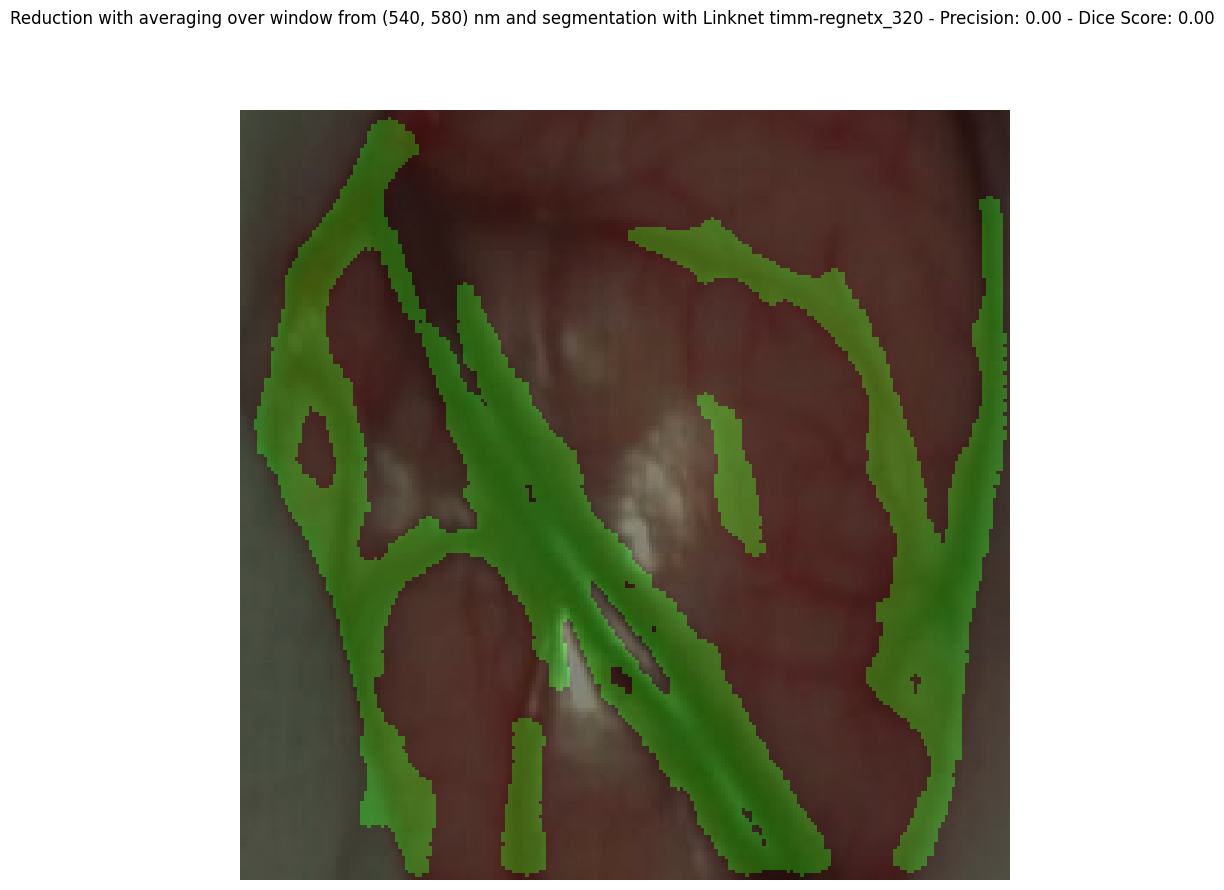

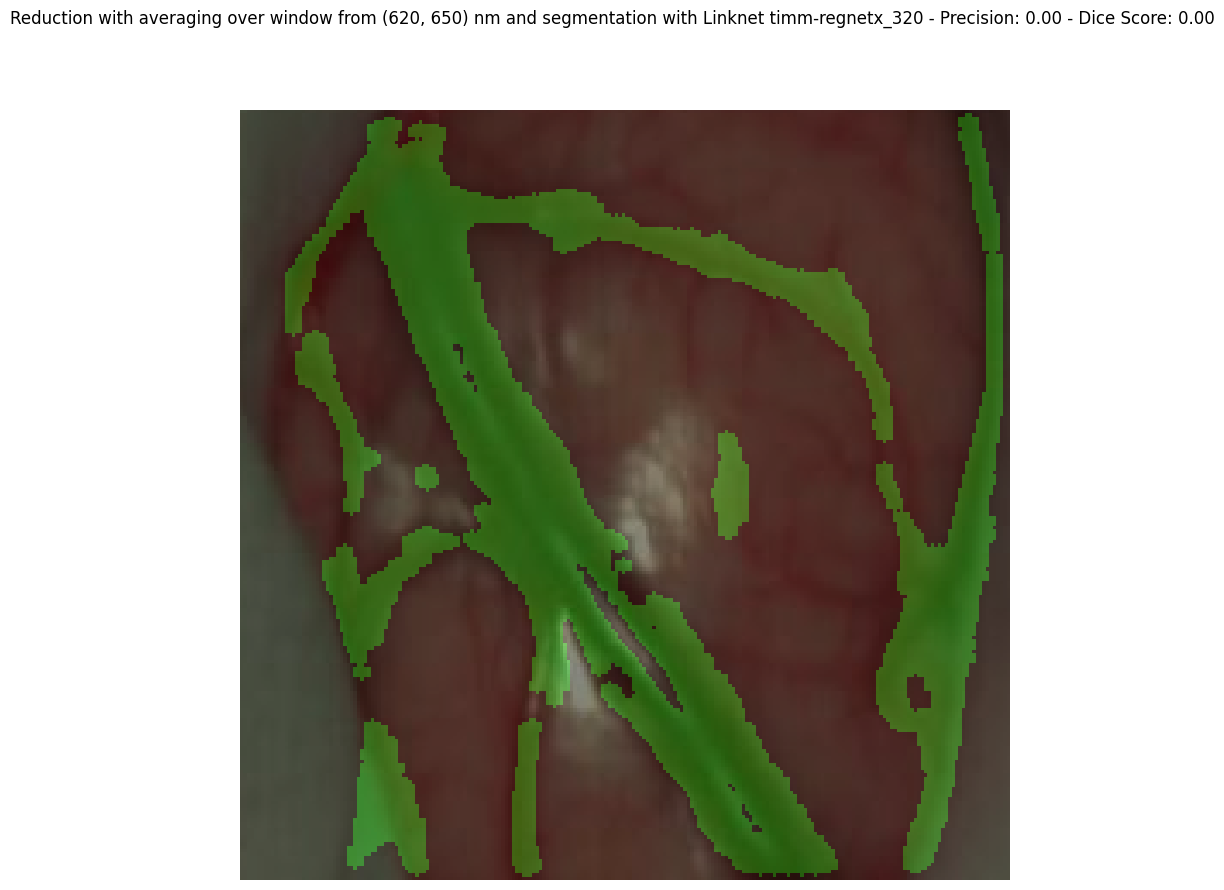

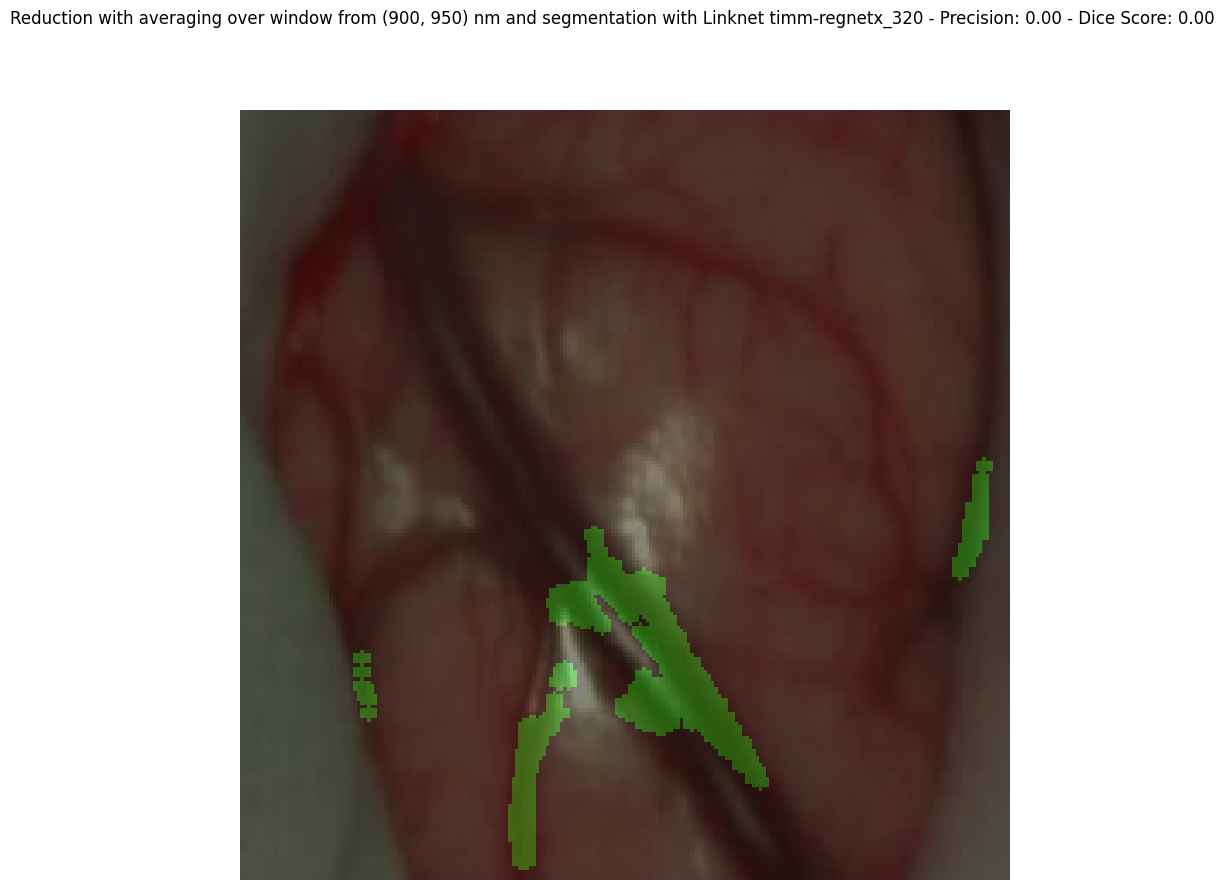

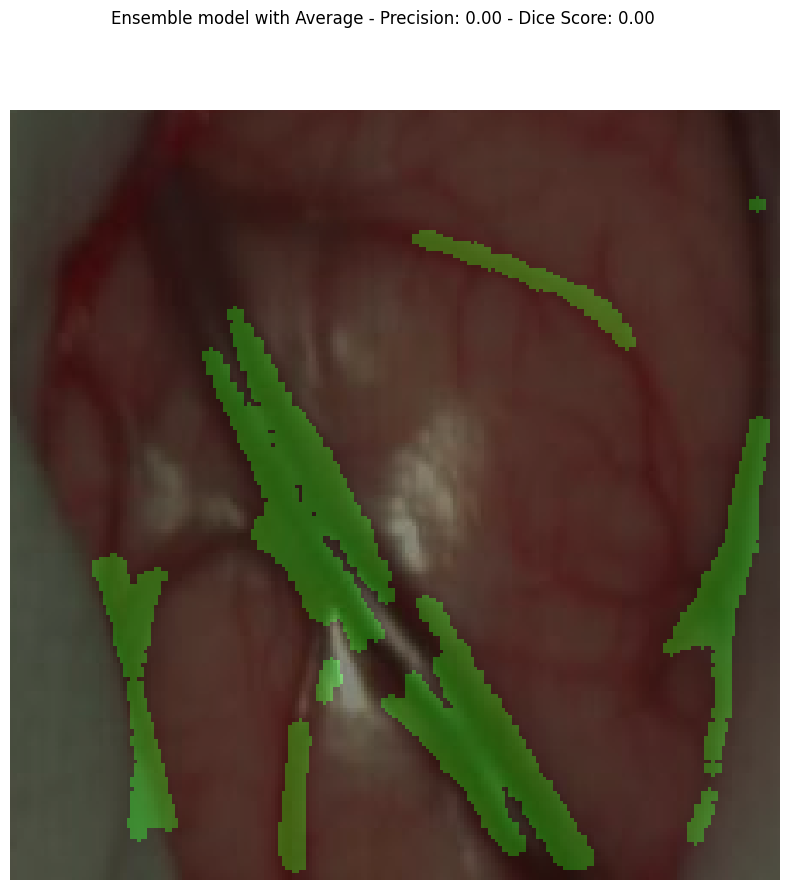

In [3]:
from src.model.HSI_models.HSI_Net import SegmentationModelWithWindowing
from src.util.segmentation_util import show_overlay, build_segmentation_model, load_model
from src.model.HSI_models.ensemble_model import EnsembleModelAverage
from src.util.constants import MODELS_DIR
import torch

device = ('cuda:1' if torch.cuda.is_available() else 'cpu')
data = dataset[35]

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

model_path_segmenter = MODELS_DIR / f"{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth"
segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel = load_model(segmenter_single_channel, model_path_segmenter, device=device)
segmenter_single_channel.eval()

window_full = (400, 1100)
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window_full))

window1 = (700, 900)
model_windowing_700to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window1))


window2 = (500, 600)
# segmenter_windowed = smp.UnetPlusPlus('resnext101_32x8d', in_channels=1, classes=1)
# segmenter_windowed.load_state_dict(torch.load('./models/UnetPlusPlus-resnext101_32x8d-512x512-augmented-with-random-crops-single-channel.pth'))
# segmenter_windowed.to(device)

model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window2))

window3 = (540, 580)
window4 = (620, 650)
window5 = (900, 950)

model_windowing_540to580 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window3))
model_windowing_620to650 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window4))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window5))

threshold = 0.6

show_overlay(model_window_full, data, device, title='Reduction with averaging over full window and segmentation with {architecture} {encoder}'.format(architecture=architecture, encoder=encoder), threshold=threshold)


show_overlay(model_with_windowing_500to600, data, device, title='Reduction with averaging over window {window2} nm and segmentation with {architecture} {encoder}'.format(window2=window2, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_700to900, data, device, title='Reduction with averaging over window from {window1} nm and segmentation with {architecture} {encoder}'.format(window1=window1, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_540to580, data, device, title='Reduction with averaging over window from {window3} nm and segmentation with {architecture} {encoder}'.format(window3=window3, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_620to650, data, device, title='Reduction with averaging over window from {window4} nm and segmentation with {architecture} {encoder}'.format(window4=window4, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_900to1000, data, device, title='Reduction with averaging over window from {window5} nm and segmentation with {architecture} {encoder}'.format(window5=window5, architecture=architecture, encoder=encoder), threshold=threshold)


model = EnsembleModelAverage([model_with_windowing_500to600, model_windowing_700to900, model_windowing_620to650, model_windowing_900to1000, model_window_full])
output = model_window_full(data[0].unsqueeze(0).to(device))

show_overlay(model, data, device, with_sigmoid=False, title='Ensemble model with Average', threshold=threshold)

## Visualization of different Thresholds

In [ ]:
from src.model.HSI_models.HSI_Net import SegmentationModelWithWindowing
from src.util.segmentation_util import build_segmentation_model, load_model, show_interactive_overlay
from src.util.constants import MODELS_DIR
import torch
import torch

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
data = dataset[34]

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

model_path_segmenter = MODELS_DIR / f"{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth"
segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel = load_model(segmenter_single_channel, model_path_segmenter, device=device)
segmenter_single_channel.eval()

window = (400, 1000)
model_with_windowing = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window))
title = 'Reduction with averaging over window {window} and segmentation with {architecture} {encoder}'.format(window=window, architecture=architecture, encoder=encoder)

show_interactive_overlay(model_with_windowing, data, device, title=title)

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='Reduct…

# Evaluation

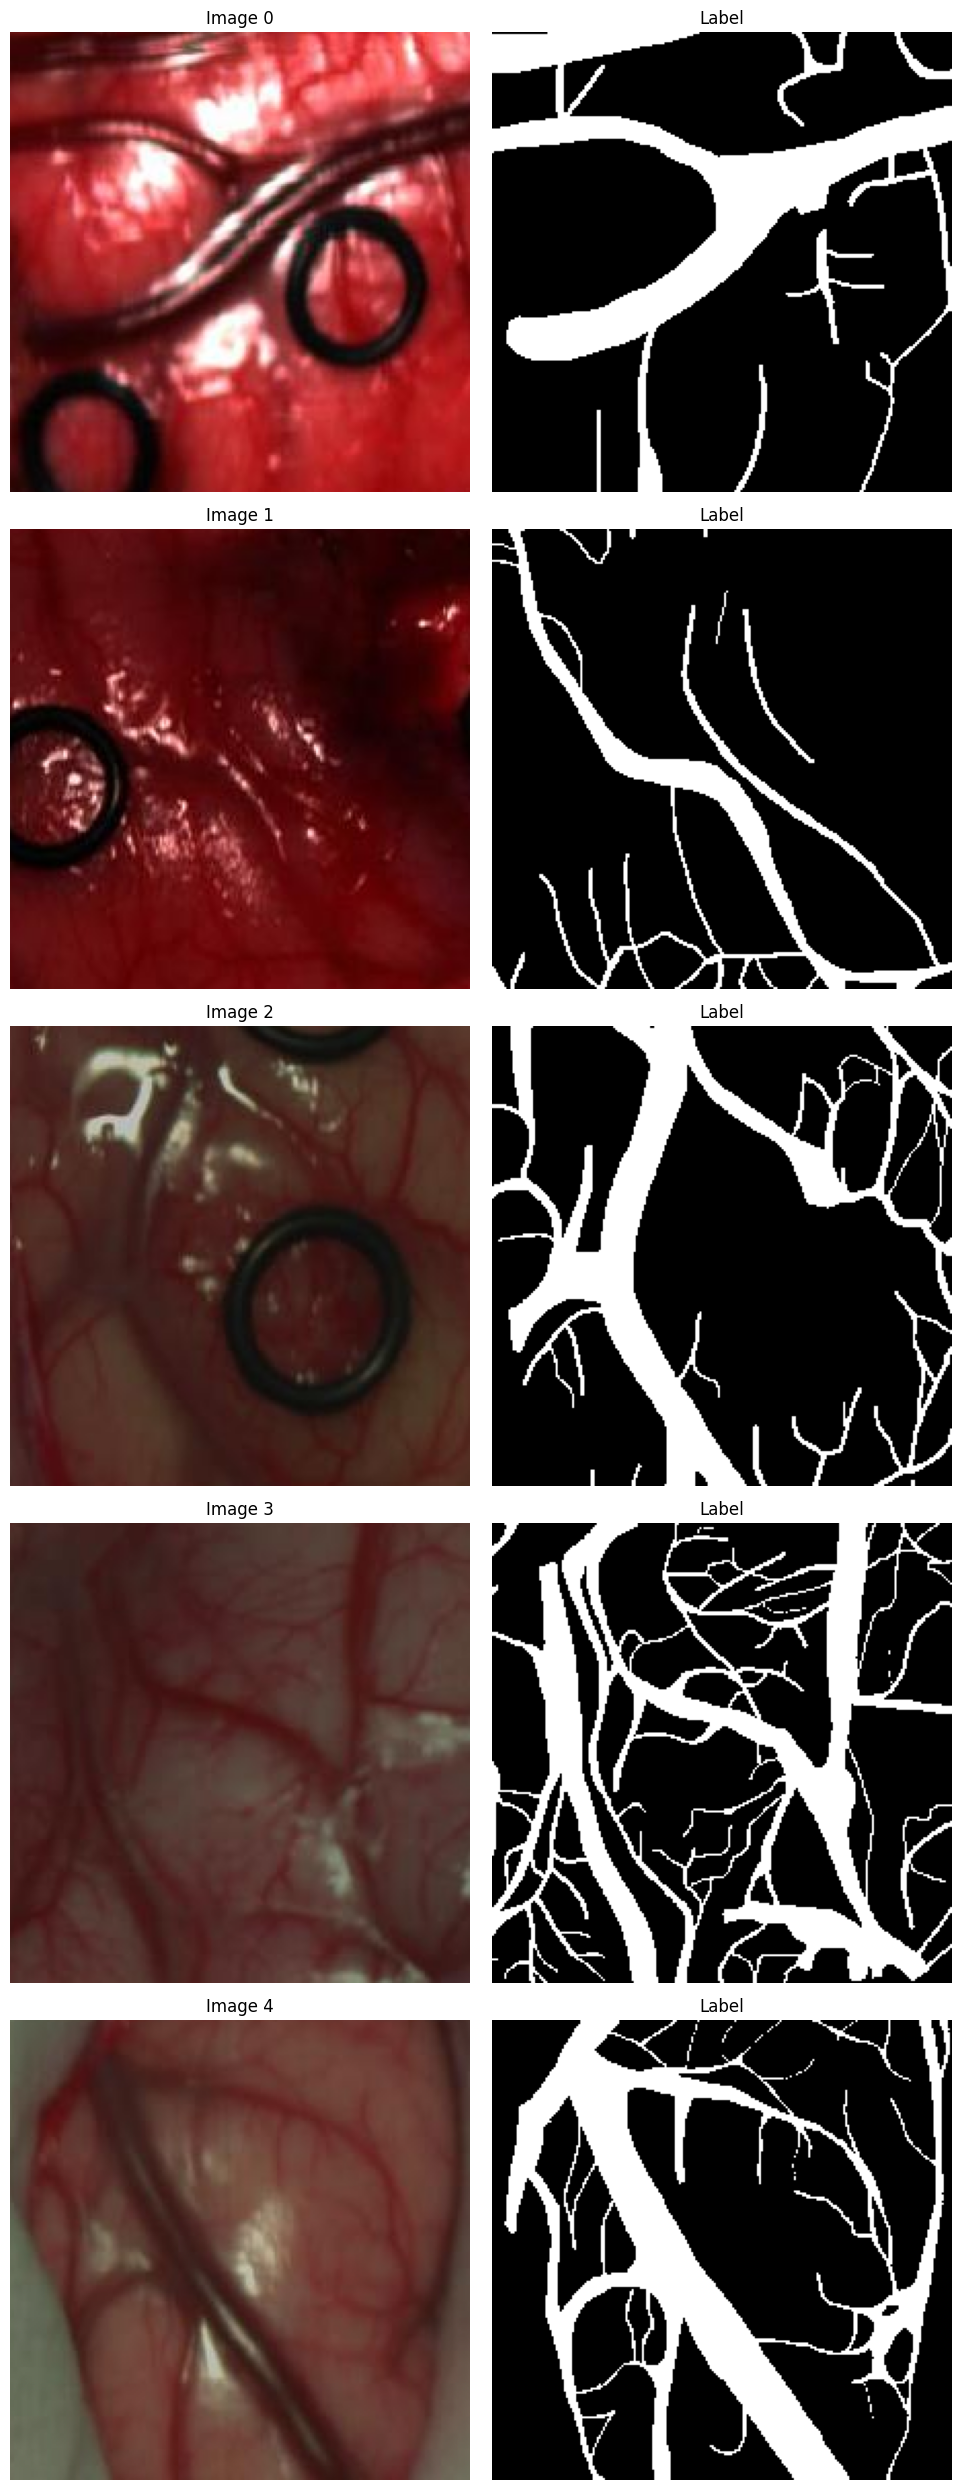

In [ ]:
from src.dataset.dataset import HSIDataset, create_montage
import matplotlib.pyplot as plt
import numpy as np
from src.util.constants import HELICOID_WITH_LABELS_DIR

evaluation_dataset = HSIDataset(HELICOID_WITH_LABELS_DIR, with_gt=True, window=(500,600))
evaluation_dataset.crop_dataset()
create_montage(evaluation_dataset, num_images=5)

## Ensemble Model

In [ ]:
from src.model.HSI_models.HSI_Net import SegmentationModelWithWindowing
from src.util.segmentation_util import build_segmentation_model, show_interactive_overlay, load_model
from src.util.constants import MODELS_DIR
from src.model.HSI_models.ensemble_model import EnsembleModelAverage
import torch

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
data = evaluation_dataset[0]

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

model_path_segmenter = MODELS_DIR / f"{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth"
segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel = load_model(segmenter_single_channel, model_path_segmenter, device=device)
segmenter_single_channel.eval()

window1 = (400, 500)
window2 = (500, 600)
window3 = (600, 700)
window4 = (700, 800)
window5 = (800, 900)
window6 = (900, 1000)
window_full = (400, 1100)


model_windowing_400to500 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window1))
model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window2))
model_windowing_600to700 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window3))
model_windowing_700to800 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window4))
model_windowing_800to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window5))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window6))
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window_full))

model = EnsembleModelAverage([model_windowing_400to500, model_with_windowing_500to600, model_windowing_600to700, model_windowing_700to800, model_windowing_900to1000, model_window_full])
title = 'Ensemble Model with averaging and segmentation with {architecture} {encoder}'.format(architecture=architecture, encoder=encoder)

show_interactive_overlay(model, data, device, title=title)

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='Ensemb…